In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder,  StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [2]:
df = pd.read_csv("data/german_credit_data.csv")
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [3]:
df.drop(columns=["Unnamed: 0"], inplace=True)

## Fill NA Values in Saving accounts and Checking account

In [4]:
df.fillna("unknown", inplace=True)
df.isna().sum().to_frame()

,0
Age,0
Sex,0
Job,0
Housing,0
Saving accounts,0
Checking account,0
Credit amount,0
Duration,0
Purpose,0


## Pipeline

In [5]:
columns_to_encode = ["Sex", "Housing", "Saving accounts", "Checking account", "Purpose"]

In [6]:
ct = ColumnTransformer(
    [
        ("encoder", OneHotEncoder(), columns_to_encode)
    ],
    remainder="passthrough",
    force_int_remainder_cols=False
)

In [7]:
model = KMeans(
    n_clusters=4,
    max_iter=500,
    random_state=42
)

In [8]:
pipe = Pipeline(
    [
        ("column_transformer", ct),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=3)),
        ("model", model)
    ]
)

In [9]:
pipe.named_steps

{'column_transformer': ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                   transformers=[('encoder', OneHotEncoder(),
                                  ['Sex', 'Housing', 'Saving accounts',
                                   'Checking account', 'Purpose'])]),
 'scaler': StandardScaler(),
 'pca': PCA(n_components=3),
 'model': KMeans(max_iter=500, n_clusters=4, random_state=42)}

In [10]:
pipe.fit(df)
X_scaled_array = pipe[:-1].transform(df)

C:\Users\Jaycp\miniconda3\envs\adm\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [11]:
print(f"PCA reduced the features to: {pipe.named_steps['pca'].n_components_} components (to retain 95% variance)")

PCA reduced the features to: 3 components (to retain 95% variance)


C:\Users\Jaycp\miniconda3\envs\adm\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Jaycp\miniconda3\envs\adm\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Jaycp\miniconda3\envs\adm\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Jaycp\miniconda3\envs\adm\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans 

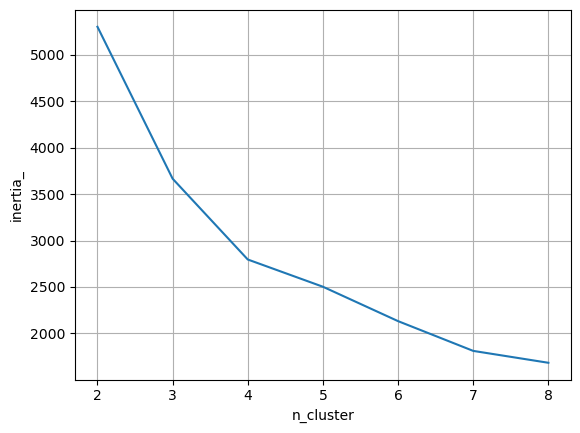

In [12]:
k_clusters = range(2, 9)
inertia = []
for i in k_clusters:
    model_k = KMeans(n_clusters=i, random_state=42, max_iter=500)
    model_k.fit(X_scaled_array)
    inertia.append(model_k.inertia_)

plt.plot(k_clusters, inertia)
plt.xlabel("n_cluster")
plt.ylabel("inertia_")
plt.grid()
plt.show()

## Calculate silhouette_score & find best cluster value

In [13]:
s_score = silhouette_score(X_scaled_array, pipe.predict(df))
s_score

np.float64(0.3323333000361362)

C:\Users\Jaycp\miniconda3\envs\adm\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Jaycp\miniconda3\envs\adm\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Jaycp\miniconda3\envs\adm\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Jaycp\miniconda3\envs\adm\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans 

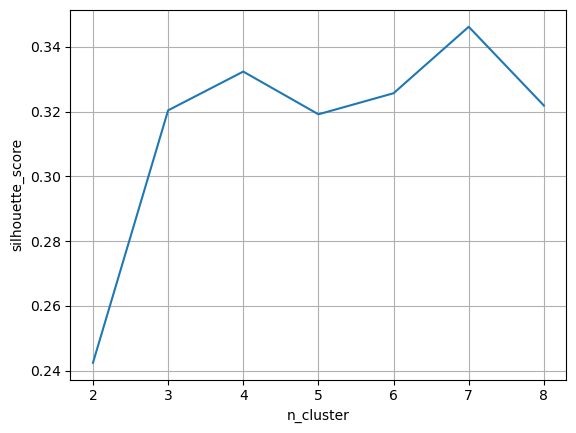

In [14]:
k_clusters = range(2, 9)
s_score = []
for i in k_clusters:
    model_k = KMeans(n_clusters=i, random_state=42, max_iter=500)
    pipe.steps[-1] = ('model', model_k)
    s_score.append(silhouette_score(X_scaled_array, pipe.fit_predict(df)))

plt.plot(k_clusters, s_score)
plt.xlabel("n_cluster")
plt.ylabel("silhouette_score")
plt.grid()
plt.show()

### Trying to find best hyperparameters through optuna

In [15]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    n_clusters = trial.suggest_int("n_clusters", 2, 10)
    random_state = trial.suggest_int("random_state", 0, 50)
    max_iter = trial.suggest_int("max_iter", 50, 500, 50) 

    model_k = KMeans(n_clusters=n_clusters, random_state=random_state, max_iter=max_iter)
    pipe.steps[-1] = ('model', model_k)
    pipe.fit(df)
    data = pipe[:-1].transform(df)
    s_score = silhouette_score(data, pipe.predict(df))

    return s_score

study = optuna.create_study(direction='maximize')
study.optimize(objective,  n_trials=100)

C:\Users\Jaycp\AppData\Local\Temp\ipykernel_7300\2981264507.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  max_iter = trial.suggest_int("max_iter", 50, 500, 50)
C:\Users\Jaycp\miniconda3\envs\adm\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Jaycp\AppData\Local\Temp\ipykernel_7300\2981264507.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they wer

In [16]:
study.best_trial

FrozenTrial(number=50, state=TrialState.COMPLETE, values=[0.36305003207692005], datetime_start=datetime.datetime(2025, 12, 10, 18, 37, 0, 409510), datetime_complete=datetime.datetime(2025, 12, 10, 18, 37, 0, 470348), params={'n_clusters': 9, 'random_state': 44, 'max_iter': 300}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_clusters': IntDistribution(high=10, log=False, low=2, step=1), 'random_state': IntDistribution(high=50, log=False, low=0, step=1), 'max_iter': IntDistribution(high=500, log=False, low=50, step=50)}, trial_id=50, value=None)

In [17]:
study.best_params

{'n_clusters': 9, 'random_state': 44, 'max_iter': 300}

In [18]:
model_k = KMeans(n_clusters=7, random_state=16, max_iter=450)
pipe.steps[-1] = ('model', model_k)
pipe.fit(df)
data = pipe[:-1].transform(df)
s_score = silhouette_score(data, pipe.predict(df))
s_score

C:\Users\Jaycp\miniconda3\envs\adm\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


np.float64(0.3557038821753687)

## Cluster Intrepretation

In [19]:
df_predict = df.copy()
df_predict["cluster"] = pipe.predict(df_predict)
df_predict.sample(8)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,cluster
230,26,male,2,own,little,rich,4210,36,radio/TV,1
222,30,male,2,own,little,unknown,707,12,radio/TV,1
439,26,female,0,own,little,rich,609,12,business,4
954,29,female,2,own,little,little,1893,12,car,4
579,27,male,1,own,little,unknown,937,24,education,1
213,66,male,3,own,little,rich,1908,30,business,1
55,26,male,1,own,unknown,unknown,783,6,car,0
476,24,male,2,own,quite rich,unknown,2569,39,car,0


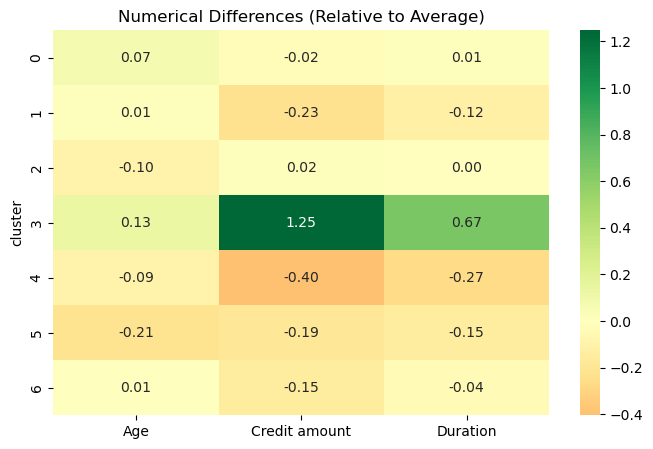

In [20]:
num_cols = ['Age', 'Credit amount', 'Duration']

cluster_means = df_predict.groupby('cluster')[num_cols].mean()
population_means = df_predict[num_cols].mean()
relative_imp = cluster_means / population_means - 1

plt.figure(figsize=(8, 5))
sns.heatmap(relative_imp, annot=True, fmt='.2f', cmap='RdYlGn', center=0)
plt.title("Numerical Differences (Relative to Average)")
plt.show()

In [21]:
age_mapping = {0:"Older", 1:"Very Young", 2:"Young", 3:"Young"}
credit_mapping = {0:"Very High Spender", 1:"Very Low Spender", 2:"High Spender", 3:"Low Spender"}
duration_mapping = {0:"Long", 1:"Short", 2:"Medium", 3:"Very Short"}



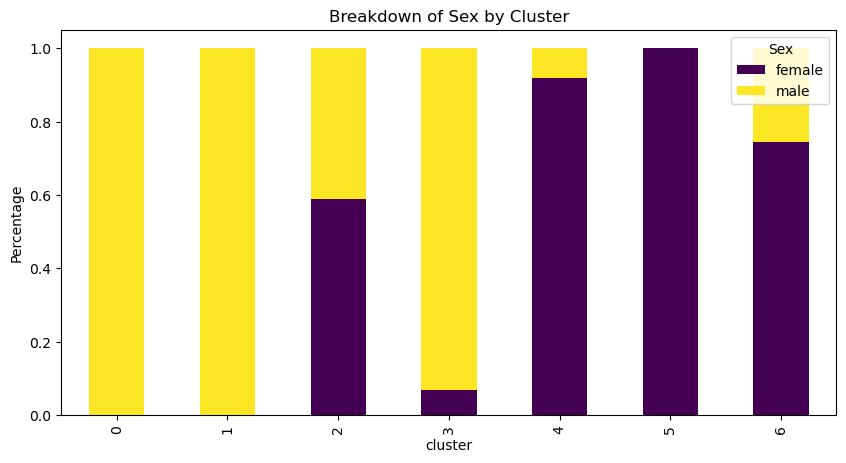

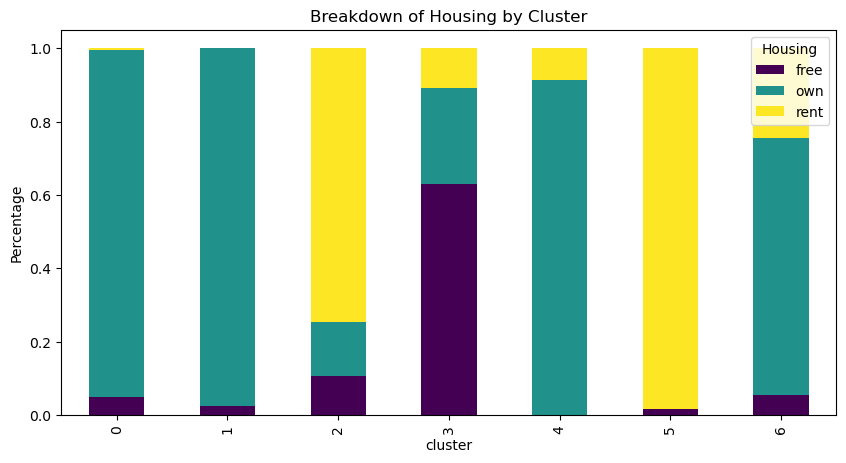

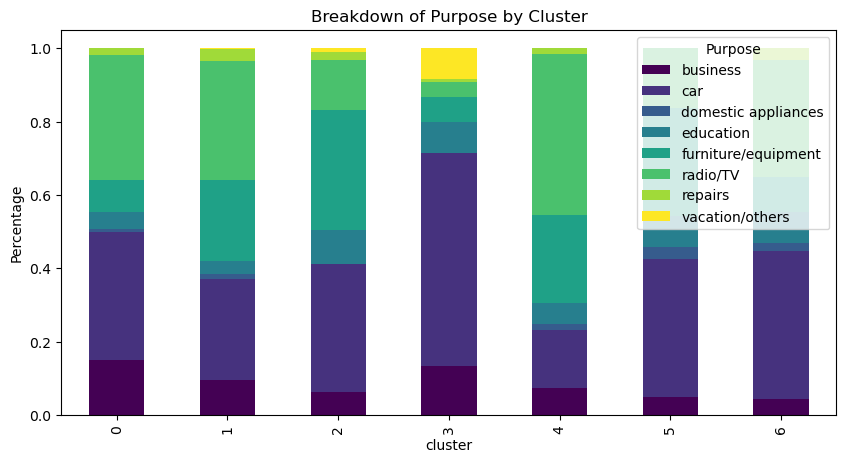

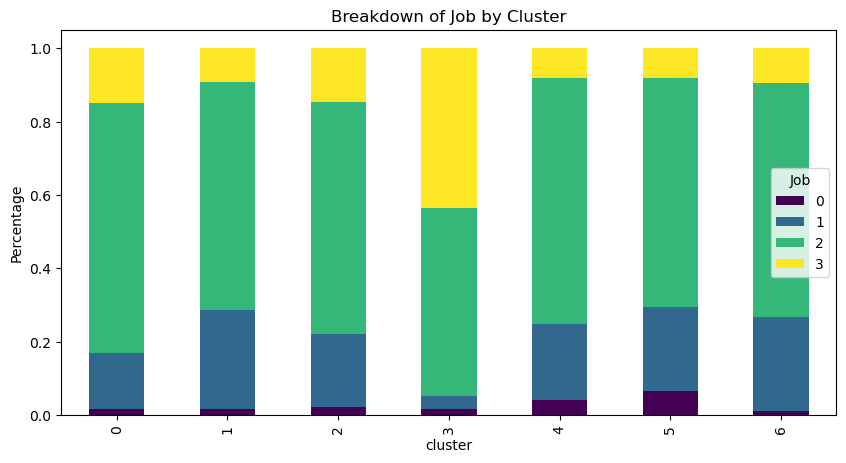

In [22]:
cat_cols = ['Sex', 'Housing', 'Purpose', 'Job']

for col in cat_cols:
    cross_tab = pd.crosstab(df_predict['cluster'], df_predict[col], normalize='index')
    
    cross_tab.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='viridis')
    plt.title(f"Breakdown of {col} by Cluster")
    plt.ylabel("Percentage")
    plt.show()

In [23]:
cat_cols = ['Sex', 'Housing', 'Purpose', 'Job']
cat_mappings = {}

for col in cat_cols:
    modes = df_predict.groupby('cluster')[col].agg(lambda x: x.mode()[0])
    cat_mappings[col] = modes.to_dict()
    
    print(f"Mapping for {col}: {cat_mappings[col]}")

Mapping for Sex: {0: 'male', 1: 'male', 2: 'female', 3: 'male', 4: 'female', 5: 'female', 6: 'female'}
Mapping for Housing: {0: 'own', 1: 'own', 2: 'rent', 3: 'free', 4: 'own', 5: 'rent', 6: 'own'}
Mapping for Purpose: {0: 'car', 1: 'radio/TV', 2: 'car', 3: 'car', 4: 'radio/TV', 5: 'car', 6: 'car'}
Mapping for Job: {0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2}


In [24]:
df_data_profile = df_predict[["cluster"]].copy()
df_data_profile['Age_Segment'] = df_data_profile['cluster'].map(age_mapping)
df_data_profile['Credit_Segment'] = df_data_profile['cluster'].map(credit_mapping)
df_data_profile['Duration_Segment'] = df_data_profile['cluster'].map(duration_mapping)

for col, mapping in cat_mappings.items():
    df_data_profile[f'{col}_Segment'] = df_data_profile['cluster'].map(mapping)

cols_to_show = ['cluster', 'Age_Segment', 'Credit_Segment', 'Duration_Segment', 
                'Sex_Segment', 'Housing_Segment', 'Purpose_Segment']

df_data_profile = df_data_profile.drop_duplicates().sort_values(by="cluster").reset_index(drop=True)
df_data_profile

,cluster,Age_Segment,Credit_Segment,Duration_Segment,Sex_Segment,Housing_Segment,Purpose_Segment,Job_Segment
0,0,Older,Very High Spender,Long,male,own,car,2
1,1,Very Young,Very Low Spender,Short,male,own,radio/TV,2
2,2,Young,High Spender,Medium,female,rent,car,2
3,3,Young,Low Spender,Very Short,male,free,car,2
4,4,NaN,NaN,NaN,female,own,radio/TV,2
5,5,NaN,NaN,NaN,female,rent,car,2
6,6,NaN,NaN,NaN,female,own,car,2


In [25]:
final_label = {0:"High Risk / High Reward.",
              1:"Medium Risk / Low Reward",
              2:"Low Risk / Medium Reward",
              3:"Lowest Risk / Low Reward"}

df_data_profile["Business Profile"] = df_data_profile["cluster"].map(final_label)
df_data_profile

,cluster,Age_Segment,Credit_Segment,Duration_Segment,Sex_Segment,Housing_Segment,Purpose_Segment,Job_Segment,Business Profile
0,0,Older,Very High Spender,Long,male,own,car,2,High Risk / High Reward.
1,1,Very Young,Very Low Spender,Short,male,own,radio/TV,2,Medium Risk / Low Reward
2,2,Young,High Spender,Medium,female,rent,car,2,Low Risk / Medium Reward
3,3,Young,Low Spender,Very Short,male,free,car,2,Lowest Risk / Low Reward
4,4,NaN,NaN,NaN,female,own,radio/TV,2,NaN
5,5,NaN,NaN,NaN,female,rent,car,2,NaN
6,6,NaN,NaN,NaN,female,own,car,2,NaN


In [26]:
df_predict.to_csv("data/df_predicted.csv")
df_data_profile.to_csv("data/data_profile.csv")

## Test

In [27]:
def classify_new_user(record):
    df_test = pd.DataFrame([record])
    cluster= pipe.predict(df_test)[0]
    return df_data_profile[df_data_profile["cluster"]==cluster]["Business Profile"].iloc[0]

In [28]:
new_user = {
    'Age': 35, 'Sex': 'male', 'Job': 2, 'Housing': 'own', 
    'Saving accounts': 'little', 'Checking account': 'rich', 
    'Credit amount': 4000, 'Duration': 24, 'Purpose': 'radio/TV'
}

print(f"\n--- Prediction for New User ---")
print(classify_new_user(new_user))


--- Prediction for New User ---
Medium Risk / Low Reward


In [29]:
import pickle
pickle.dump(pipe, open("pipe.pkl", "wb"))


In [30]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,unknown,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,unknown,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car
